## parsing harps website

* [HARPS bank](http://www.mpia.de/homes/trifonov/HARPS_RVBank.html)

In [1]:
from urllib.request import urlopen, urlretrieve
from os.path import exists
from os.path import join
import sys

import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_3d
from astropy.io import ascii
from astroplan.plots import plot_finder_image
import matplotlib.pyplot as pl
from astropy.visualization.wcsaxes import SphericalCircle
import matplotlib.cm as cm
from collections import OrderedDict
import numpy as np
from tqdm import tqdm
from glob import glob
import sys
sys.path.append('..')
import archive_digger as ad

In [2]:
df = ad.get_harps_database(clobber=False)

Loaded: ../data/harps_db.csv


In [3]:
ra=279.272#+2/60
dec=5.292#+2/60

target = SkyCoord(ra=ra, dec=dec, unit=u.deg)
res = ad.query_target(target, df, dist=10*u.arcsec)
res


Querying objects within 10.0 arcsec" of ra,dec=(279.272,5.292)

There are 1 matches: ['BD+053829']
                                                                      0
Data product plots                                  BD+053829_plots.pdf
Pre-upgrade DRS                            BD+053829_harps_pre-drs.vels
Post-upgrade DRS                                                    NaN
Pre-upgrade standard SERVAL             BD+053829_harps_pre-serval.vels
Post-upgrade standard SERVAL                                        NaN
Pre-upgrade mlc SERVAL (use these)  BD+053829_harps_pre_serval-mlc.vels
Post-upgrade mlc SERVAL(use these)                                  NaN




,Target,RA,DEC,Sp. Type,T_eff [K],V [mag],G [mag],Data product plots,Pre-upgrade DRS,Post-upgrade DRS,Pre-upgrade standard SERVAL,Post-upgrade standard SERVAL,Pre-upgrade mlc SERVAL (use these),Post-upgrade mlc SERVAL(use these),RA_deg,DEC_deg
0,BD+053829,18:37:05.2146,+05:17:31.620,G5,4872.9,9.8,9.4,BD+053829_plots.pdf,BD+053829_harps_pre-drs.vels,NaN,BD+053829_harps_pre-serval.vels,NaN,BD+053829_harps_pre_serval-mlc.vels,NaN,279.271727,5.292117


In [4]:
toi = 704.01
q = ad.query_toi(toi=toi, tic=None, clobber=True)
r = q['RA'].values[0]
d = q['Dec'].values[0]
target_coord = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg))
res = ad.query_target(target, df, dist=10*u.arcsec)
res

Saved: ../data/TOIs.csv

Querying objects within 10.0 arcsec" of ra,dec=(279.272,5.292)

There are 1 matches: ['BD+053829']
                                                                      0
Data product plots                                  BD+053829_plots.pdf
Pre-upgrade DRS                            BD+053829_harps_pre-drs.vels
Post-upgrade DRS                                                    NaN
Pre-upgrade standard SERVAL             BD+053829_harps_pre-serval.vels
Post-upgrade standard SERVAL                                        NaN
Pre-upgrade mlc SERVAL (use these)  BD+053829_harps_pre_serval-mlc.vels
Post-upgrade mlc SERVAL(use these)                                  NaN




,Target,RA,DEC,Sp. Type,T_eff [K],V [mag],G [mag],Data product plots,Pre-upgrade DRS,Post-upgrade DRS,Pre-upgrade standard SERVAL,Post-upgrade standard SERVAL,Pre-upgrade mlc SERVAL (use these),Post-upgrade mlc SERVAL(use these),RA_deg,DEC_deg
0,BD+053829,18:37:05.2146,+05:17:31.620,G5,4872.9,9.8,9.4,BD+053829_plots.pdf,BD+053829_harps_pre-drs.vels,NaN,BD+053829_harps_pre-serval.vels,NaN,BD+053829_harps_pre_serval-mlc.vels,NaN,279.271727,5.292117


In [5]:
res.columns

Index(['Target', 'RA', 'DEC', 'Sp. Type', 'T_eff [K]', 'V [mag]', 'G [mag]',
       'Data product plots', 'Pre-upgrade DRS', 'Post-upgrade DRS',
       'Pre-upgrade standard SERVAL', 'Post-upgrade standard SERVAL',
       'Pre-upgrade mlc SERVAL (use these)',
       'Post-upgrade mlc SERVAL(use these)', 'RA_deg', 'DEC_deg'],
      dtype='object')

In [6]:
ad.ALL_DATA_PRODUCTS

['Data product plots',
 'Pre-upgrade DRS',
 'Post-upgrade DRS',
 'Pre-upgrade standard SERVAL',
 'Post-upgrade standard SERVAL',
 'Pre-upgrade mlc SERVAL (use these)',
 'Post-upgrade mlc SERVAL(use these)']

In [7]:
r = res.iloc[0]
rv = ad.get_rv(r, col='Pre-upgrade DRS', return_fp=False)
rv

,col1,col2,col3
0,2453450.873,-25653.956,0.885
1,2453462.868,-25647.876,0.999
2,2453499.801,-25644.227,4.456
3,2453500.744,-25652.905,1.558
4,2453521.740,-25643.707,1.247
5,2453593.690,-25653.209,1.276
6,2456454.807,-25653.637,1.066
7,2456525.632,-25648.987,2.957
8,2456538.589,-25651.804,1.071


## finder chart

In [13]:
target_coord = SkyCoord(ra=target_coord.ra.deg, dec=target_coord.dec.deg, unit=(u.deg, u.deg))

In [14]:
res

,Target,RA,DEC,Sp. Type,T_eff [K],V [mag],G [mag],Data product plots,Pre-upgrade DRS,Post-upgrade DRS,Pre-upgrade standard SERVAL,Post-upgrade standard SERVAL,Pre-upgrade mlc SERVAL (use these),Post-upgrade mlc SERVAL(use these),RA_deg,DEC_deg
0,BD+053829,18:37:05.2146,+05:17:31.620,G5,4872.9,9.8,9.4,BD+053829_plots.pdf,BD+053829_harps_pre-drs.vels,NaN,BD+053829_harps_pre-serval.vels,NaN,BD+053829_harps_pre_serval-mlc.vels,NaN,279.271727,5.292117


In [ ]:
toi = 704.01
ang_dist = 30*u.arcsec
fov_rad = 120*u.arcsec
survey='DSS2 Red'

q = ad.query_toi(toi=toi, tic=None, clobber=False)
r = q['RA'].values[0]
d = q['Dec'].values[0]
target_coord = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg))
#convert hms to degree
target_coord = SkyCoord(target_coord.ra.deg, target_coord.dec.deg, unit=u.deg)
res = ad.query_target(target_coord, df, dist=ang_dist, verbose=False)

nearest_obj = res['Target'].values[0]
nearest_obj_ra,nearest_obj_dec =res[['RA_deg','DEC_deg']].values[0]
nearest_obj_coord = SkyCoord(ra=nearest_obj_ra, dec=nearest_obj_dec, unit=u.deg)

#target in reticle
ax,hdu=plot_finder_image(target_coord,fov_radius=fov_rad,reticle=True,survey=survey,reticle_style_kwargs={'label':'target'})
c = SphericalCircle((nearest_obj_ra, nearest_obj_dec)*u.deg, ang_dist, edgecolor='green', facecolor='none',
              transform=ax.get_transform('icrs'), label='query radius')
ax.set_title('{} ({})'.format(survey,nearest_obj))
ax.add_patch(c)

#harps objects within angular distance
coords = SkyCoord(ra=res['RA_deg'], dec=res['DEC_deg'], unit=u.deg)
sep2d = target_coord.separation(coords)

idxs = sep2d < ang_dist
colors = cm.rainbow(np.linspace(0, 1, idxs.sum()))

if len(coords[idxs])>1:
    for n,(coord,color) in enumerate(zip(coords[idxs],colors)):
        ax.scatter(coord.ra.deg, coord.dec.deg, transform=ax.get_transform('fk5'), s=300,
           marker='s', edgecolor=color, facecolor='none',label=res.loc[idxs,'Target'].values[n])
else:
    ax.scatter(coords.ra.deg, coords.dec.deg, transform=ax.get_transform('fk5'), s=300,
           marker='s', edgecolor='blue', facecolor='none',label=res['Target'])

handles, labels = pl.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys())

In [16]:
fl = glob('../all_tois/tic*')

tics = []
for f in fl:
    tics.append(f.split('/')[-1][3:])
len(tics)

49

In [17]:
tois = ad.get_tois()

Saved: ../data/TOIs.csv


100%|██████████| 49/49 [00:00<00:00, 275.34it/s]


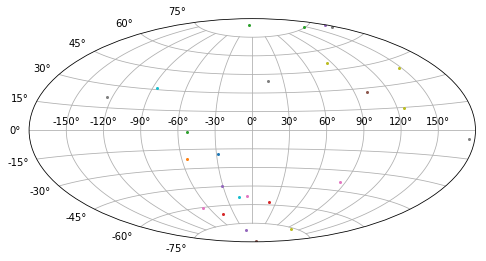

In [18]:
fig = pl.figure(figsize=(8,4.2))
ax = pl.subplot(111, projection="aitoff")

idxs = []
for tic in tqdm(tics):
    q = tois[tois['TIC ID']==int(tic)]
    idxs.append(q.index[0])
    r = q['RA'].values[0]
    d = q['Dec'].values[0]
    target_coord = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg))
    pl.plot(target_coord.ra.deg, target_coord.dec.deg, 'o', markersize=2)
pl.grid(True)
pl.subplots_adjust(top=0.95,bottom=0.0)

In [19]:
q.columns

Index(['TIC ID', 'TOI', 'Previous CTOI', 'Master', 'SG1A', 'SG1B', 'SG2',
       'SG3', 'SG4', 'SG5', 'TESS Disposition', 'TFOPWG Disposition',
       'TESS Mag', 'TESS Mag err', 'Planet Name', 'Planet Num', 'Source', 'RA',
       'Dec', 'PM RA (mas/yr)', 'PM RA err (mas/yr)', 'PM Dec (mas/yr)',
       'PM RA (mas/yr).1', 'Epoch (BJD)', 'Epoch (BJD) err', 'Period (days)',
       'Period (days) err', 'Duration (hours)', 'Duration (hours) err',
       'Depth (mmag)', 'Depth (mmag) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth)', 'Planet Radius (R_Earth) err',
       'Planet Insolation (Earth Flux)', 'Planet Equil Temp (K)', 'Planet SNR',
       'Stellar Distance (pc)', 'Stellar Distance (pc) err',
       'Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
       'Stellar log(g) (cm/s^2)', 'Stellar log(g) (cm/s^2) err',
       'Stellar Radius (R_Sun)', 'Stellar Radius (R_Sun) err', 'Sectors',
       'Date TOI Created (UTC)', 'Date TOI Modified (UTC)', 'Comments'],

In [20]:
# observed tois
o = tois.loc[idxs]
o.shape

(49, 50)

In [21]:
cols = ['TESS Mag','TIC ID','TOI','Depth (mmag)','Planet Radius (R_Earth)','Period (days)','Stellar Radius (R_Sun)','Stellar Eff Temp (K)']

s = o[cols].sort_values(by='TESS Mag',ascending=True)
s.reset_index()

,index,TESS Mag,TIC ID,TOI,Depth (mmag),Planet Radius (R_Earth),Period (days),Stellar Radius (R_Sun),Stellar Eff Temp (K)
0,46,5.097000,261136679,144.01,0.314561,1.722310,6.267726,1.381960,5992.1001
1,95,6.953410,279741379,186.01,1.009393,2.556572,NaN,0.739077,4628.5298
2,589,7.309000,55092869,664.01,2.647894,13.692776,4.736094,3.066790,5326.0000
3,360,7.652000,143350972,440.01,0.370878,2.075540,1.081700,1.108340,5771.4600
4,109,7.771000,410214986,200.01,3.889551,7.780000,8.137500,1.193480,5414.0000
5,123,7.965000,167415965,214.01,0.481733,1.982974,18.552747,0.900064,5346.1699
6,350,8.113401,31374837,431.01,2.227239,3.867820,12.459410,0.802493,4891.0000
7,88,8.141000,207141131,179.01,1.232507,2.813921,4.137394,0.838949,5058.0000
8,319,8.265090,120896927,402.01,0.441054,1.899079,4.755833,0.887665,5175.2002
9,171,8.429280,37749396,260.01,0.745653,1.637881,13.470018,0.631587,4111.0000


In [30]:
ad.query_toi(toi=144.01)[['RA','Dec']]

Saved: ../data/TOIs.csv


,RA,Dec
46,05:37:11.76,-80:27:53.1


In [31]:
46 in idxs

True

In [33]:
s.to_csv('TOI_with_harps_data.csv',index=False)

In [34]:
s['TOI'].to_csv('TOI_with_harps_data.txt',index=False)

In [10]:
ra_from_simbad ='05:37:09.8851202601 '
dec_from_simbad='-80:28:08.831347245'

ra_from_alerts = '05:37:11.76'
dec_from_alerts= '-80:27:53.1'
 
sc1 = SkyCoord(ra=ra_from_simbad,dec=dec_from_simbad,unit=(u.hourangle,u.deg))
sc2 = SkyCoord(ra=ra_from_alerts,dec=dec_from_alerts,unit=(u.hourangle,u.deg))

In [11]:
sc1.separation(sc2)

<Angle 0.00455733 deg>